In [1]:
from datasets.celeba.classification_dataloader import Classification_Dataloader
from image_toolbox.image_utils.visualization_utils import visualize_torch_batch

In [2]:
!pwd

/home/kareem/PycharmProjects/Classification-Pytorch/classification/src


In [3]:
# load configurations
from omegaconf import OmegaConf
conf = OmegaConf.load("../conf/default.yaml")
conf

{'datasets': {'celeba': {'base_url': '/home/kareem/PycharmProjects/Classification-Pytorch/classification/data/celeba', 'zip_file_name': 'img_align_celeba.zip', 'data_dir_name': 'img_align_celeba', 'labels_txt_file': 'identity_CelebA.txt', 'split_txt_file': 'list_eval_partition.txt'}}}

In [4]:
celeba = Classification_Dataloader(conf=conf.datasets.celeba)
celeba.setup()

size of train, val, test dataset 162770 19867 19962


tensor([ 1627,  1474,  2442,  9747,  7561,  2846,  4013,   145,  1466,  8156,
         3669,  1727,  5997,  5124,  3059,  5932,  8772,  7627,  6011, 10103,
         2627,  3882,  4340,  5551,  2231,  2578,  9764,  1989,  9686,  6558,
         8052,  8830])
torch.Size([32, 3, 218, 178])



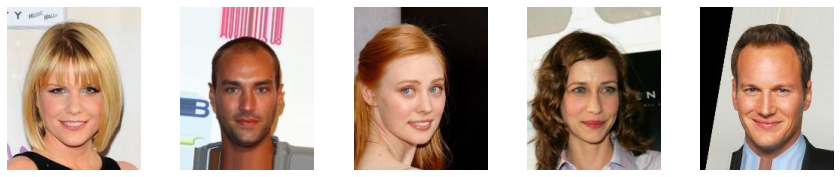

In [5]:
for batch in celeba.train_dataloader():
    imgs, labels = batch
    print(labels)
    print(imgs.shape)
    print()
    visualize_torch_batch(imgs)
    break